Episode 200/200 | Score: -21.00 | Avg(5): -20.80 | Epsilon: 0.367


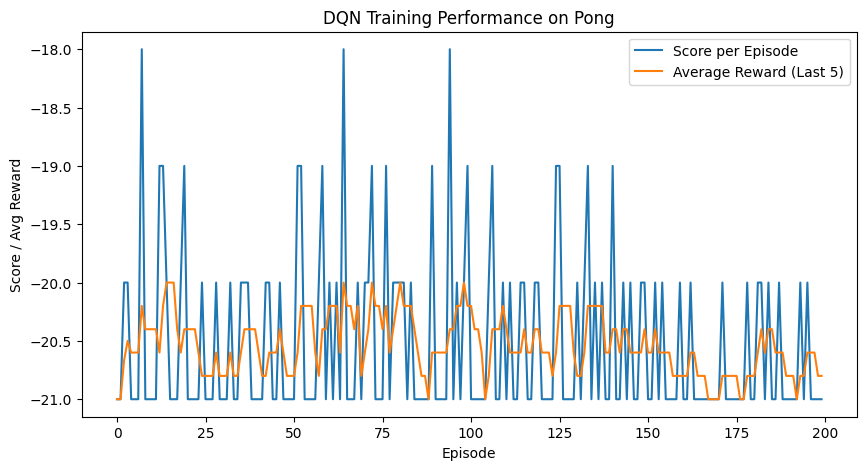

✅ Model checkpoint saved at episode 200
Training complete ✅


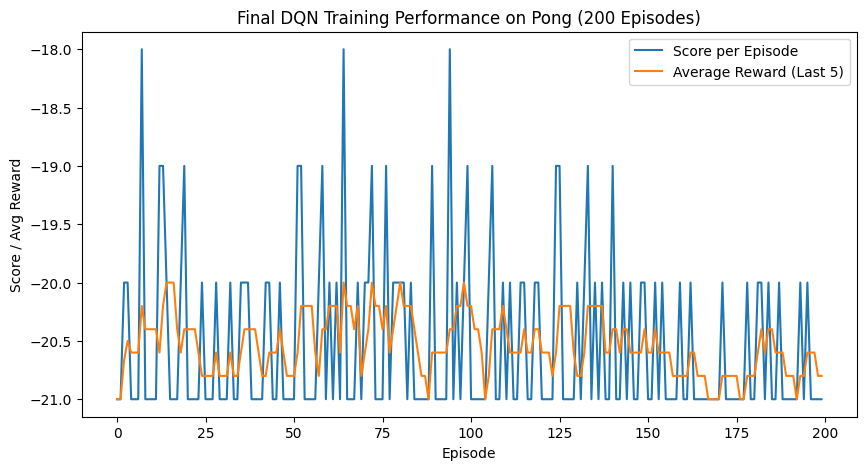

In [2]:
# === FIX NUMPY BOOL ISSUE (for Gym compatibility) ===
import numpy as np
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

# === IMPORTS ===
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

# ================================================================
# 1. CNN MODEL FOR DQN
# ================================================================
class DQN(nn.Module):
    def __init__(self, input_shape=(4, 84, 80), n_actions=6):
        super(DQN, self).__init__()
        c, h, w = input_shape

        self.conv1 = nn.Conv2d(c, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w, 8, 4), 4, 2), 3, 1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h, 8, 4), 4, 2), 3, 1)
        linear_input_size = convw * convh * 64

        self.fc1 = nn.Linear(linear_input_size, 512)
        self.fc2 = nn.Linear(512, n_actions)

    def forward(self, x):
        x = x / 255.0
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ================================================================
# 2. MEMORY-OPTIMIZED REPLAY BUFFER
# ================================================================
class ReplayMemory:
    def __init__(self, capacity=20000):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        # store as uint8 to save memory
        self.buffer.append((
            state.astype(np.uint8),
            action,
            reward,
            next_state.astype(np.uint8),
            done
        ))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # convert back to float32 for model input
        states = np.array(states, dtype=np.float32)
        next_states = np.array(next_states, dtype=np.float32)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

# ================================================================
# 3. FRAME PREPROCESSING
# ================================================================
def process_frame(img, image_shape):
    img = img[30:-12, :, :]             # crop
    img = img[::2, ::2]                 # downsample
    img = np.mean(img, axis=2).astype(np.uint8)  # grayscale
    img = (img - 128) / 128.0           # normalize [-1, 1]
    return img.reshape(image_shape)     # (84, 80)

def transform_reward(reward):
    return np.sign(reward)

# ================================================================
# 4. EPSILON-GREEDY POLICY
# ================================================================
def select_action(model, state, epsilon, n_actions, device):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    with torch.no_grad():
        state_tensor = torch.tensor(np.array([state]), dtype=torch.float32).to(device)
        q_values = model(state_tensor)
        return int(torch.argmax(q_values).item())

# ================================================================
# 5. TRAINING FUNCTION
# ================================================================
def train_dqn(num_episodes=200, batch_size=8, target_update=10):
    ENV_ID = "PongDeterministic-v4"
    env = gym.make(ENV_ID)
    n_actions = env.action_space.n
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    policy_net = DQN().to(DEVICE)
    target_net = DQN().to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
    memory = ReplayMemory(20000)

    epsilon, eps_min, eps_decay = 1.0, 0.05, 0.995
    gamma = 0.95

    scores, avg_rewards = [], []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        frame = process_frame(obs, (84, 80))
        state = np.stack([frame] * 4, axis=0)
        done = False
        total_reward = 0

        while not done:
            action = select_action(policy_net, state, epsilon, n_actions, DEVICE)
            next_obs, reward, done, _, _ = env.step(action)
            reward = transform_reward(reward)
            next_frame = process_frame(next_obs, (84, 80))
            next_state = np.concatenate((state[1:], np.expand_dims(next_frame, 0)), axis=0)

            memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(memory) >= batch_size:
                states, actions, rewards, next_states, dones = memory.sample(batch_size)

                states = torch.tensor(states, dtype=torch.float32).to(DEVICE)
                actions = torch.tensor(actions).unsqueeze(1).to(DEVICE)
                rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(DEVICE)
                next_states = torch.tensor(next_states, dtype=torch.float32).to(DEVICE)
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(DEVICE)

                q_values = policy_net(states).gather(1, actions)
                next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
                expected_q_values = rewards + gamma * next_q_values * (1 - dones)

                loss = nn.MSELoss()(q_values, expected_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # update target network
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # decay epsilon
        epsilon = max(eps_min, epsilon * eps_decay)
        scores.append(total_reward)
        avg_reward = np.mean(scores[-5:]) if len(scores) >= 5 else np.mean(scores)
        avg_rewards.append(avg_reward)

        # live progress every 10 episodes
        if (episode + 1) % 10 == 0:
            clear_output(wait=True)
            print(f"Episode {episode+1}/{num_episodes} | Score: {total_reward:.2f} | "
                  f"Avg(5): {avg_reward:.2f} | Epsilon: {epsilon:.3f}")

            plt.figure(figsize=(10, 5))
            plt.plot(scores, label="Score per Episode")
            plt.plot(avg_rewards, label="Average Reward (Last 5)")
            plt.legend()
            plt.title("DQN Training Performance on Pong")
            plt.xlabel("Episode")
            plt.ylabel("Score / Avg Reward")
            plt.show()

        # save checkpoint every 100 episodes
        if (episode + 1) % 100 == 0:
            torch.save(policy_net.state_dict(), f"dqn_pong_ep{episode+1}.pth")
            print(f"✅ Model checkpoint saved at episode {episode+1}")

    env.close()
    print("Training complete ✅")

    plt.figure(figsize=(10, 5))
    plt.plot(scores, label="Score per Episode")
    plt.plot(avg_rewards, label="Average Reward (Last 5)")
    plt.legend()
    plt.title("Final DQN Training Performance on Pong (200 Episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Score / Avg Reward")
    plt.show()

# ================================================================
# 6. RUN TRAINING (200 EPISODES)
# ================================================================
train_dqn(num_episodes=200, batch_size=8, target_update=10)


### Summary
**Best Config:**  
- **Batch:** 8  
- **Update:** 10  
- **Optimizer:** Adam (lr = 1e-4)  
- **Loss:** MSE  

**Result:**  
Gradual improvement and stable convergence.
